In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import json
import pprint
import seaborn as sns
import numpy as np
import random
from time import time
import pickle

In [91]:
from pymongo import MongoClient
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [92]:
def SaveDict(filename, mode, root):
    if filename[-4:]!=".txt":
        filename+=".txt"
    with open(filename, mode) as f:
        f.write(pprint.pformat(root))

def LoadDict(filename):
    if filename[-4:]!=".txt":
        filename+=".txt"
    with open(filename, "r") as f:
        return eval(f.read())

In [93]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [94]:
client = MongoClient()
db = client.twitter

In [95]:
texts = []
for article in db.articles.find():
    doc = article['text']

    doc = doc.replace("\n"," ")
    doc = doc.replace("\'","")

    doc = gensim.utils.simple_preprocess(doc)

    wordnet_lemmatizer = WordNetLemmatizer()
    doc = [wordnet_lemmatizer.lemmatize(word) for word in doc]
    doc = [wordnet_lemmatizer.lemmatize(word,pos='v') for word in doc]

    en_stop = get_stop_words('en')
    letters = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]
    other = ["wa","ha","one","two","id","re","http","com","mr","image","photo","caption","don","sen","pic","co",
             "source","watch","play","duration","video","momentjs","getty","images","newsletter", "story", "go", "like", "say",
             "will", "just", "today", "can", "year", "make", "view", "read"]
    doc = [word for word in doc if not word in (en_stop+letters+other)]
    db.articles.update_one({"_id": article["_id"]}, {"$set": {"clean_text": doc}})
    texts.append(doc)

In [96]:
random.seed(42)
train_set = random.sample(list(range(0,len(texts))),len(texts)-1000)
test_set = [x for x in list(range(0,len(texts))) if x not in train_set]

train_texts = [texts[i] for i in train_set]
test_texts = [texts[i] for i in test_set]

pickle.dump([train_set,test_set,train_texts,test_texts],open('./data/pub_articles_train_test_sets.pkl','wb'))

In [ ]:
train_Set, test_set, train_texts, test_texts = pickle.load(open('./data/pub_articles_train_test_sets.pkl','rb'))

## tf-idf + LDA

In [11]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

dictionary = corpora.Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

ldamodels_tfidf = {}
for i in topicnums:
    random.seed(42)
    %time ldamodels_tfidf[i] = models.ldamodel.LdaModel(corpus_tfidf,num_topics=i,id2word=dictionary)
    ldamodels_tfidf[i].save('./data/ldamodels_tfidf_'+str(i)+'.lda')

CPU times: user 36.4 s, sys: 802 ms, total: 37.2 s
Wall time: 37.8 s
CPU times: user 47.9 s, sys: 773 ms, total: 48.7 s
Wall time: 49.2 s
CPU times: user 52.9 s, sys: 841 ms, total: 53.7 s
Wall time: 54.8 s
CPU times: user 54.1 s, sys: 1.12 s, total: 55.2 s
Wall time: 55.2 s
CPU times: user 55.2 s, sys: 944 ms, total: 56.2 s
Wall time: 56.6 s
CPU times: user 59.3 s, sys: 764 ms, total: 1min
Wall time: 1min
CPU times: user 1min 6s, sys: 1.8 s, total: 1min 8s
Wall time: 1min 9s
CPU times: user 1min 12s, sys: 1.14 s, total: 1min 14s
Wall time: 1min 15s
CPU times: user 1min 18s, sys: 1.82 s, total: 1min 20s
Wall time: 1min 22s
CPU times: user 1min 24s, sys: 1.68 s, total: 1min 26s
Wall time: 1min 27s
CPU times: user 1min 31s, sys: 1.91 s, total: 1min 33s
Wall time: 1min 35s
CPU times: user 1min 36s, sys: 2.55 s, total: 1min 39s
Wall time: 1min 40s
CPU times: user 1min 41s, sys: 2.59 s, total: 1min 43s
Wall time: 1min 44s


In [25]:
# http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
def intra_inter_tfidf(lda_model, dictionary, test_docs, num_pairs=10000):
    
    # Split each test document into two halves and compute topics for each half
    part1 = [lda_model[tfidf[dictionary.doc2bow(tokens[:int(len(tokens)/2)])]] for tokens in test_docs]
    part2 = [lda_model[tfidf[dictionary.doc2bow(tokens[int(len(tokens)/2):])]] for tokens in test_docs]   
    
    # Compute topic distribution similarities using cosine similarity
    
    #print("Average cosine similarity between corresponding parts (higher is better):")
    corresp_parts = np.mean([gensim.matutils.cossim(p1, p2) for p1, p2 in zip(part1, part2)])

    #print("Average cosine similarity between 10,000 random parts (lower is better):")    
    random.seed(42)
    random_pairs = np.random.randint(0, len(test_docs), size=(num_pairs, 2))
    random_parts = np.mean([gensim.matutils.cossim(part1[i[0]], part2[i[1]]) for i in random_pairs])
    
    return corresp_parts, random_parts

In [28]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]
ldamodels_eval = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('./data/ldamodels_tfidf_'+str(i)+'.lda')
    ldamodels_eval[i] = intra_inter_tfidf(lda_model, dictionary, test_texts)
    
pickle.dump(ldamodels_eval,open('./data/pub_ldamodels_tfidf_eval.pkl','wb'))

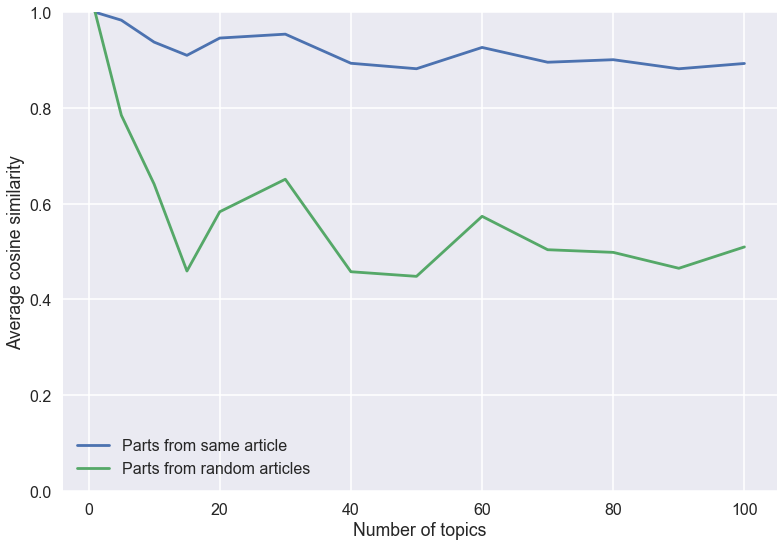

In [29]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

ldamodels_eval = pickle.load(open('./data/pub_ldamodels_tfidf_eval.pkl','rb'))
corresp_parts = [ldamodels_eval[i][0] for i in topicnums]
random_parts = [ldamodels_eval[i][1] for i in topicnums]
sns.set_context("poster")
with sns.axes_style("darkgrid"):
    x = topicnums
    y1 = corresp_parts
    y2 = random_parts
    plt.plot(x,y1,label='Parts from same article')
    plt.plot(x,y2,label='Parts from random articles')
    plt.ylim([0.0,1.0])
    plt.xlabel('Number of topics')
    plt.ylabel('Average cosine similarity')    
    plt.legend()    
    plt.show()

In [30]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

lda_topics = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('./data/ldamodels_tfidf_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

pickle.dump(lda_topics,open('./data/pub_lda_tfidf_topics.pkl','wb'))

In [31]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/float(len(union))

In [32]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims
    
pickle.dump(lda_stability,open('./data/pub_lda_tfidf_stability.pkl','wb'))

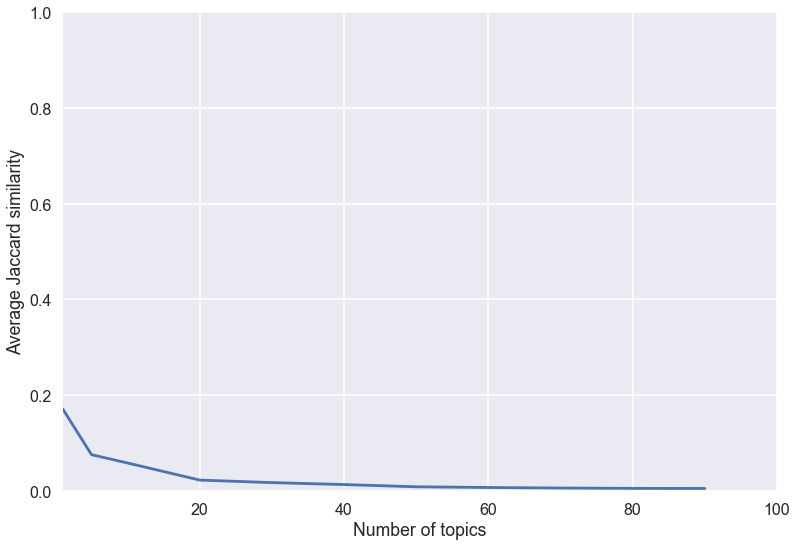

In [33]:
topicnums = [1,5,10,20,30,40,50,60,70,80,90,100]

lda_stability = pickle.load(open('./data/pub_lda_tfidf_stability.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.plot(x,y,label='Mean overlap')
    plt.xlim([1, 100])
    plt.ylim([0, 1])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')    
    #plt.legend()    
    plt.show()

## Bag of Words + LDA

In [34]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

dictionary = corpora.Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

ldamodels_bow = {}
for i in topicnums:
    random.seed(42)
    %time ldamodels_bow[i] = models.ldamodel.LdaModel(corpus,num_topics=i,id2word=dictionary)
    ldamodels_bow[i].save('./data/ldamodels_bow_'+str(i)+'.lda')

CPU times: user 30.2 s, sys: 482 ms, total: 30.7 s
Wall time: 31 s
CPU times: user 58.2 s, sys: 1.55 s, total: 59.7 s
Wall time: 1min
CPU times: user 59.1 s, sys: 608 ms, total: 59.7 s
Wall time: 59.6 s
CPU times: user 1min 4s, sys: 992 ms, total: 1min 5s
Wall time: 1min 5s
CPU times: user 1min 8s, sys: 594 ms, total: 1min 9s
Wall time: 1min 9s
CPU times: user 1min 18s, sys: 860 ms, total: 1min 18s
Wall time: 1min 18s
CPU times: user 1min 27s, sys: 956 ms, total: 1min 28s
Wall time: 1min 28s
CPU times: user 1min 36s, sys: 1.22 s, total: 1min 37s
Wall time: 1min 38s
CPU times: user 1min 46s, sys: 1.31 s, total: 1min 47s
Wall time: 1min 48s
CPU times: user 1min 56s, sys: 3.21 s, total: 1min 59s
Wall time: 2min 1s
CPU times: user 2min 4s, sys: 1.52 s, total: 2min 5s
Wall time: 2min 5s
CPU times: user 2min 12s, sys: 1.68 s, total: 2min 14s
Wall time: 2min 14s
CPU times: user 2min 22s, sys: 2.26 s, total: 2min 25s
Wall time: 2min 25s


In [35]:
# http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
def intra_inter_bow(lda_model, dictionary, test_docs, num_pairs=10000):
    
    # Split each test document into two halves and compute topics for each half
    part1 = [lda_model[dictionary.doc2bow(tokens[:int(len(tokens)/2)])] for tokens in test_docs]
    part2 = [lda_model[dictionary.doc2bow(tokens[int(len(tokens)/2):])] for tokens in test_docs]   
    
    # Compute topic distribution similarities using cosine similarity
    
    #print("Average cosine similarity between corresponding parts (higher is better):")
    corresp_parts = np.mean([gensim.matutils.cossim(p1, p2) for p1, p2 in zip(part1, part2)])

    #print("Average cosine similarity between 10,000 random parts (lower is better):")    
    random.seed(42)
    random_pairs = np.random.randint(0, len(test_docs), size=(num_pairs, 2))
    random_parts = np.mean([gensim.matutils.cossim(part1[i[0]], part2[i[1]]) for i in random_pairs])
    
    return corresp_parts, random_parts

In [36]:
ldamodels_eval = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('./data/ldamodels_bow_'+str(i)+'.lda')
    ldamodels_eval[i] = intra_inter_bow(lda_model, dictionary, test_texts)
    
pickle.dump(ldamodels_eval,open('./data/pub_ldamodels_bow_eval.pkl','wb'))

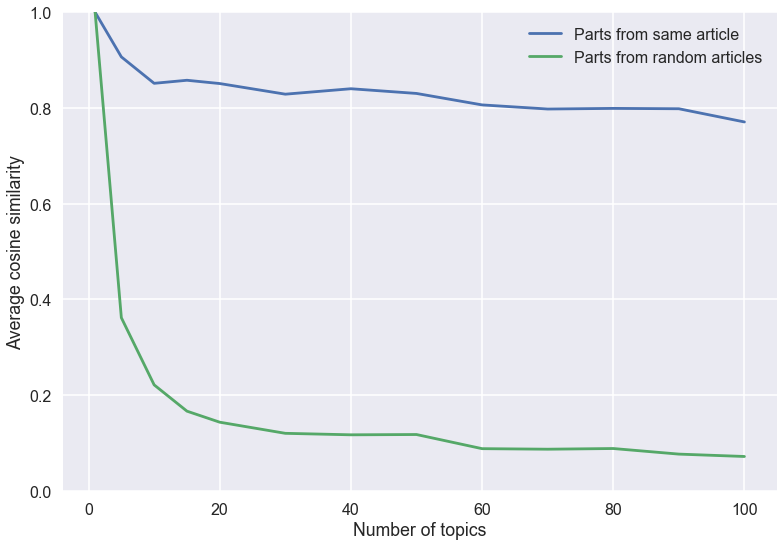

In [37]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

ldamodels_eval = pickle.load(open('./data/pub_ldamodels_bow_eval.pkl','rb'))
corresp_parts = [ldamodels_eval[i][0] for i in topicnums]
random_parts = [ldamodels_eval[i][1] for i in topicnums]
sns.set_context("poster")
with sns.axes_style("darkgrid"):
    x = topicnums
    y1 = corresp_parts
    y2 = random_parts
    plt.plot(x,y1,label='Parts from same article')
    plt.plot(x,y2,label='Parts from random articles')
    plt.ylim([0.0,1.0])
    plt.xlabel('Number of topics')
    plt.ylabel('Average cosine similarity')    
    plt.legend()    
    plt.show()

In [38]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

lda_topics = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('./data/ldamodels_bow_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

pickle.dump(lda_topics,open('./data/pub_lda_bow_topics.pkl','wb'))

In [39]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims
    
pickle.dump(lda_stability,open('./data/pub_lda_bow_stability.pkl','wb'))

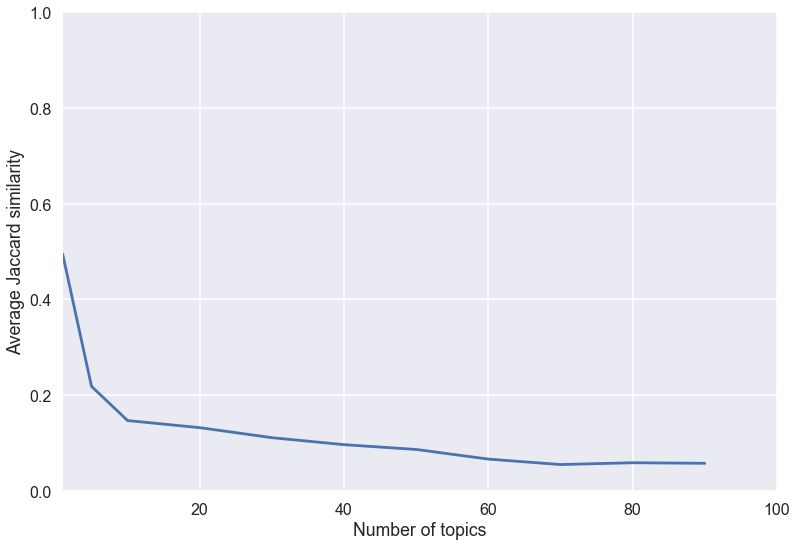

In [58]:
topicnums = [1,5,10,20,30,40,50,60,70,80,90,100]

lda_stability = pickle.load(open('./data/pub_lda_bow_stability.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.plot(x,y,label='Mean overlap')
    plt.xlim([1, 100])
    plt.ylim([0, 1])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')    
    #plt.legend()    
    plt.show()

## Optimal Model

In [97]:
num_topics = 20
lda_model = models.ldamodel.LdaModel.load('./data/ldamodels_bow_'+str(num_topics)+'.lda')

In [98]:
lda_topics = lda_model.show_topics(num_topics)
lda_topics_words = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics]
lda_topics_disp = [("topic "+str(i)+": ")+" ".join(topic) for i,topic in enumerate(lda_topics_words)]
lda_topics_disp
pickle.dump(lda_topics_disp,open('./data/pub_lda_bow_topics.pkl','wb'))

In [99]:
article_topics = {}
retweet_count = {}
for i in range(num_topics):
    db.articles.update_many({}, {"$unset": {"topic "+str(i): ""}}, upsert=True)
for article in db.articles.find():
    doc = article["clean_text"]
    doc_dict = gensim.corpora.Dictionary([doc])
    doc_corp = doc_dict.doc2bow(doc)
    doc_prob = lda_model[doc_corp]
    
    topic_prob = [0 for i in range(num_topics)]
    for prob in doc_prob:
        topic_prob[prob[0]] = prob[1] 
        
    article_topics[article["id"]] = topic_prob
    retweet_count[article["id"]] = db.posts.find_one({"id": article["id"]})["retweet_count"]
    
    for probs in doc_prob:
        db.articles.update_one({"_id": article["_id"]}, {"$set": {"topic "+str(probs[0]): probs[1]}})

### User Topic Extration

In [44]:
user_topics = {}
user_topics_reweighted = {}
for user in db.user_merge.find():
    tweets = user["tweet_ids"]
    user_id = user["_id"]
    user_topics[user_id] = np.zeros(num_topics)
    user_topics_reweighted[user_id] = np.zeros(num_topics)
    for tweet in tweets:
        if tweet in article_topics:
            user_topics[user_id] += np.array(article_topics[int(tweet)])
            if retweet_count[int(tweet)] != 0:
                user_topics_reweighted[user_id] += np.array(article_topics[int(tweet)])/float(retweet_count[int(tweet)])
    if np.sum(user_topics[user_id])!= 0:
        user_topics[user_id] /= np.sum(user_topics[user_id])
        user_topics_reweighted[user_id] /= np.sum(user_topics_reweighted[user_id])
    for i in range(num_topics):
        db.user_merge.update_one({"_id": user_id}, 
                                 {"$set": {"topic "+str(i): user_topics[user_id][i], 
                                           "topic "+str(i)+" reweighted": user_topics_reweighted[user_id][i] }})

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide


### Group Topic Extration

In [114]:
group_topics = {}
for article in db.articles.find():
    article_probs = np.zeros(num_topics)
    for i in range(num_topics):
        if "topic "+str(i) in article:
            article_probs[i] = article["topic "+str(i)]
    if "label" in article:
        if int(article["label"]) in group_topics:
            group_topics[int(article["label"])] += article_probs
        else:
            group_topics[int(article["label"])] = article_probs
for i in group_topics:
    group_topics[i]/= np.sum(group_topics[i])
pickle.dump(group_topics, open('./data/group_lda_bow_topics.pkl','wb')) 

In [109]:
tot_topics = np.zeros(num_topics)
for i in group_topics:
    tot_topics += group_topics[i]
tot_topics /= np.sum(tot_topics)

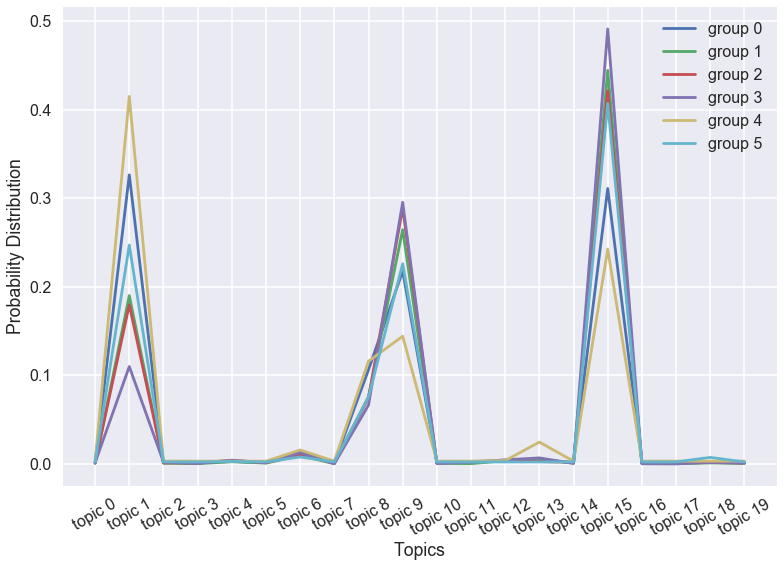

In [110]:
sns.set_context("poster")
plt.figure()
with sns.axes_style("darkgrid"):
    for i in group_topics:
        plt.plot(range(num_topics), group_topics[i], label="group "+str(i))
    plt.xlabel("Topics")
    plt.ylabel("Probability Distribution")
    plt.xticks(range(num_topics), ["topic "+str(i) for i in range(num_topics)], rotation=30)
    plt.legend()
    plt.show()

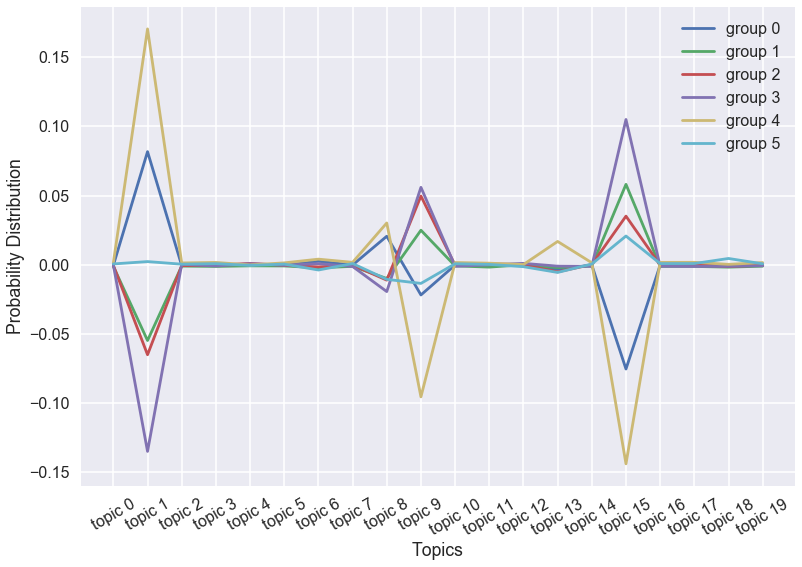

In [111]:
sns.set_context("poster")
plt.figure()
with sns.axes_style("darkgrid"):
    for i in group_topics:
        plt.plot(range(num_topics), group_topics[i]-tot_topics, label="group "+str(i))
    plt.xlabel("Topics")
    plt.ylabel("Probability Distribution")
    plt.xticks(range(num_topics), ["topic "+str(i) for i in range(num_topics)], rotation=30)
    plt.legend()
    plt.show()

In [112]:
lda_topics = pickle.load(open('./data/pub_lda_bow_topics.pkl','rb'))

In [113]:
for i in range(num_topics):
    print lda_topics[i]

topic 0: trump president saudi state first arabia house israel country washington
topic 1: main continue advertisement please time new receive error know people
topic 2: woman people show get tell time know first think life
topic 3: trump state climate president budget change continue country unite paris
topic 4: continue main advertisement city new get take time work call
topic 5: republican trump court election vote bill people democrat gianforte president
topic 6: bloomberg data new business news time information company people financial
topic 7: trump health republican president house bill care people continue tax
topic 8: location tweet trump twitter president add history learn always delete
topic 9: main advertisement continue trump time state president new please official
topic 10: continue time main trump new president advertisement free visit information
topic 11: percent continue company market main advertisement bank new china time
topic 12: continue main school student adve